In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math
import itertools
import xlrd
import random

#imports for classification
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler

#heavy weight classifier tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier

#specific imports for synthetic data creating
from imblearn.over_sampling import SMOTE

## Function Definition

In [42]:
def plot_confusion_matrix(cm):
    # plot the confusion matrix
    plt.figure(figsize=(10,10))
    plt.matshow(cm, fignum=1)
    
    # add labels for all targets
    num_targets = cm.shape[0]
    plt.xticks(list(range(num_targets+1)))
    plt.yticks(list(range(num_targets+1)))

## Data Loading and Synthetic Data Generation

In [4]:
labeledDF = pd.read_excel('Labelled_Data.xlsx', sheet_name='Output')

In [5]:
#separating data into test and train sets BEFORE oversampling to prevent overfitting
X = labeledDF.loc[:, labeledDF.columns != 'Building_Typology']
y = labeledDF.loc[:, labeledDF.columns == 'Building_Typology']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))

In [10]:
#class imbalance in the training set before SMOTE
y_train['Building_Typology'].value_counts()

Detached House      4190
Attached House      1021
Small Commercial     447
Apartment            381
Office               256
Institutional        178
Industrial            95
Commercial            75
Name: Building_Typology, dtype: int64

In [11]:
#class imbalance in the test set (will not SMOTE the test set)
y_test['Building_Typology'].value_counts()

Detached House      1772
Attached House       447
Small Commercial     186
Apartment            170
Office               117
Institutional         67
Industrial            53
Commercial            35
Name: Building_Typology, dtype: int64

In [13]:
#using SMOTE to generate sythetic training data 

sm= SMOTE(random_state=42)
xTrainRes, yTrainRes = sm.fit_resample(X_train, y_train)

C:\Anaconda\envs\warmup\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
xPrinter = pd.DataFrame(xTrainRes, columns=X_train.columns)
yPrinter = pd.DataFrame(yTrainRes, columns=y_train.columns )
yPrinter['Building_Typology'].value_counts()

Industrial          4190
Commercial          4190
Office              4190
Small Commercial    4190
Attached House      4190
Apartment           4190
Institutional       4190
Detached House      4190
Name: Building_Typology, dtype: int64

In [35]:
#saving SMOTE X and y to excel for further analysis
writer = pd.ExcelWriter('SMOTE_Output.xlsx', engine='xlsxwriter')
xPrinter.to_excel(writer, sheet_name='X')
yPrinter.to_excel(writer, sheet_name='Y')
writer.save()

## Classification Using Naive Bayes, as this was overwritten in the previous notebook

In [44]:
clf_GS = GaussianNB().fit(X_train, y_train)

In [45]:
clf_GS.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [46]:
#WITH LAT AND LON SECTOR
# predict on train and test set (random forest)
y_train_predict = clf_GS.predict(X_train)
y_test_predict = clf_GS.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))
#not exceptional performance, can we really not get into the high 90s for this?
#MN has roughly 86% test accuracy
#GS has roughly 88% test accuracy
#BL has roughly 79% test accuracy

Train accuracy: 0.651512870691
Test accuracy: 0.652616789603


## Classification using most successful method from previous iteration

In [36]:
clf2 = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)

In [37]:
clf2.fit(xPrinter, yPrinter)

C:\Anaconda\envs\warmup\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [39]:
#WITH LAT AND LON SECTOR
# predict on train and test set (random forest)
y_train_predict2 = clf2.predict(xPrinter)
y_test_predict2 = clf2.predict(X_test)

# calculate train and test accuracy
train_accuracy2 = accuracy_score(yPrinter, y_train_predict2)
test_accuracy2 = accuracy_score(y_test, y_test_predict2)

# report results
print("Train accuracy: {}".format(train_accuracy2))
print("Test accuracy: {}".format(test_accuracy2))

Train accuracy: 0.781443914081
Test accuracy: 0.640674394099


In [40]:
unique_label = np.unique(y_test)
resultDF = pd.DataFrame(confusion_matrix(y_test, y_test_predict2, labels=unique_label), index=['true:{:}'.format(x) for x in unique_label],columns=['pred:{:}'.format(x) for x in unique_label])

In [41]:
resultDF

,pred:Apartment,pred:Attached House,pred:Commercial,pred:Detached House,pred:Industrial,pred:Institutional,pred:Office,pred:Small Commercial
true:Apartment,69,17,12,15,6,12,19,20
true:Attached House,16,267,9,123,2,7,6,17
true:Commercial,6,4,8,8,1,2,3,3
true:Detached House,32,266,17,1385,10,13,3,46
true:Industrial,2,2,6,11,17,4,5,6
true:Institutional,12,5,6,17,7,11,6,3
true:Office,24,13,13,5,10,7,32,13
true:Small Commercial,19,11,12,37,29,14,29,35


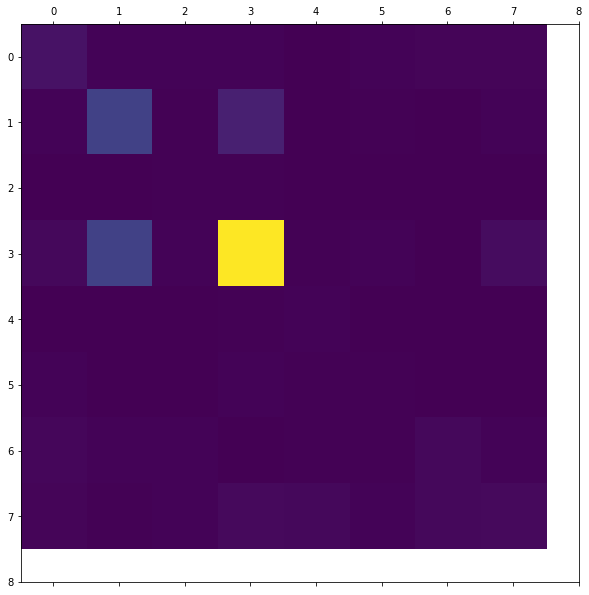

In [43]:
plot_confusion_matrix(confusion_matrix(y_test, y_test_predict2))

## Previous Algorithms using Synthetic Data

### Naive Bayes

In [47]:
clf_GS2 = GaussianNB().fit(xPrinter, yPrinter)

In [48]:
clf_GS2.fit(xPrinter, yPrinter)

GaussianNB(priors=None, var_smoothing=1e-09)

In [49]:
#WITH LAT AND LON SECTOR
# predict on train and test set (random forest)
y_train_predict = clf_GS2.predict(X_train)
y_test_predict = clf_GS2.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))
#not exceptional performance, can we really not get into the high 90s for this?
#MN has roughly 86% test accuracy
#GS has roughly 88% test accuracy
#BL has roughly 79% test accuracy

Train accuracy: 0.646695769983
Test accuracy: 0.641376887952


### Logistic Regression

In [50]:
# train a logistic regression classifier
clf_LR = LogisticRegression(C=1.0).fit(xPrinter, yPrinter)

# predict on train and test set
y_train_predict = clf_LR.predict(xPrinter)
y_test_predict = clf_LR.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(yPrinter, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

C:\Anaconda\envs\warmup\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\envs\warmup\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train accuracy: 0.347553699284
Test accuracy: 0.511766772041


### Fully Connected Neural Net

In [51]:
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(xPrinter)  
X_train = scaler.transform(xPrinter)  
# apply same transformation to test data
X_test = scaler.transform(X_test)

C:\Anaconda\envs\warmup\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [56]:
clf6 = MLPClassifier(solver='lbfgs', alpha=0.1, hidden_layer_sizes=(100, 500), random_state=random.randint(1,1000))
clf6.fit(xPrinter, yPrinter)

MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 500), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=889, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [57]:
# predict on train and test set (neural net)
y_train_predict = clf6.predict(xPrinter)
y_test_predict = clf6.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(yPrinter, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))
#not that good all in all, definitely need to do heirarchical

Train accuracy: 0.126431980907
Test accuracy: 0.0238847910081


In [58]:
unique_label = np.unique(y_test)
resultDF = pd.DataFrame(confusion_matrix(y_test, y_test_predict, labels=unique_label), index=['true:{:}'.format(x) for x in unique_label],columns=['pred:{:}'.format(x) for x in unique_label])

In [59]:
resultDF

,pred:Apartment,pred:Attached House,pred:Commercial,pred:Detached House,pred:Industrial,pred:Institutional,pred:Office,pred:Small Commercial
true:Apartment,7,13,0,0,101,0,12,37
true:Attached House,0,2,0,2,440,0,0,3
true:Commercial,1,4,0,0,28,0,2,0
true:Detached House,9,3,0,2,1753,0,3,2
true:Industrial,2,16,0,0,32,0,3,0
true:Institutional,1,11,0,1,47,0,4,3
true:Office,4,14,0,0,68,0,12,19
true:Small Commercial,4,32,0,0,129,0,8,13
